In [3]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sn
import random
from skimage.io import imread, imsave
from skimage.feature import greycomatrix, greycoprops
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
dir_imagenes_5="images_5/"
dir_labels_5="annotations_5/trimaps_5/"
dir_imagenes="images/"
dir_labels="annotations/trimaps/"
%matplotlib inline

## Ejemplos de imágenes

staffordshire_bull_terrier_15.jpg
Bombay_137.jpg
Abyssinian_128.jpg
Russian_Blue_112.jpg
Bengal_77.jpg
american_bulldog_69.jpg


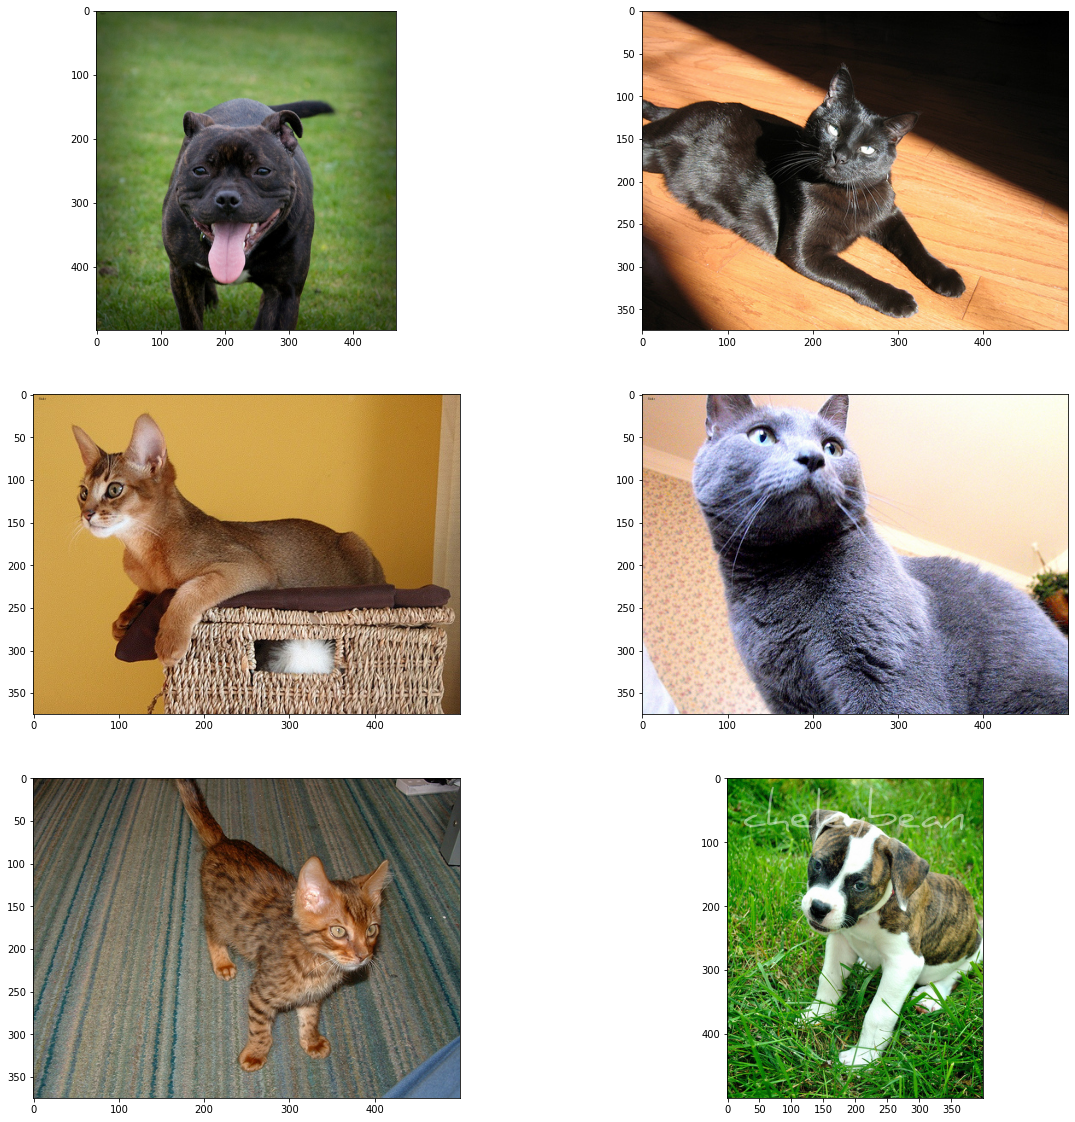

In [2]:
archivos= os.listdir(dir_imagenes)


fig, axs = plt.subplots(3,2,figsize=(20,20))
k=0
for j in range(3):
    for i in range(2):
        print(archivos[k])

        J1 = cv2.imread(dir_imagenes+archivos[k])
        J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)

        axs[j,i].imshow(J1)
        k=k+1

  


staffordshire_bull_terrier_15.jpg
Bombay_137.jpg
Abyssinian_128.jpg
Russian_Blue_112.jpg
Bengal_77.jpg
american_bulldog_69.jpg


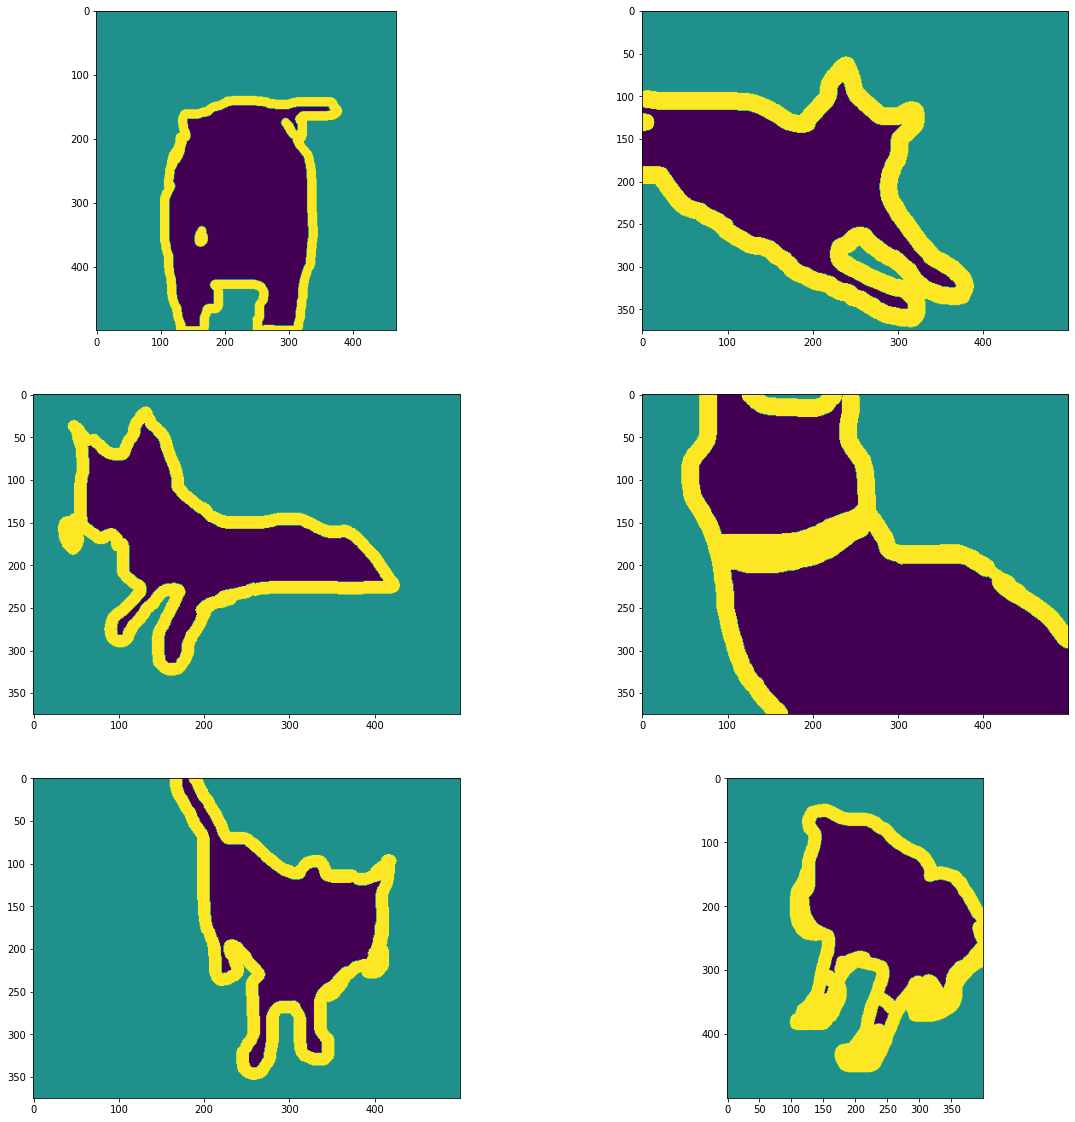

In [4]:
from skimage.io import imread, imsave
#archivos= os.listdir(dir_labels)


fig, axs = plt.subplots(3,2,figsize=(20,20))
k=0
for j in range(3):
    for i in range(2):
        print(archivos[k])
        J1=imread(dir_labels+archivos[k].replace('.jpg','.png'))
       # J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
        axs[j,i].imshow(J1)
        k=k+1


## Segmentación

<Figure size 432x288 with 0 Axes>

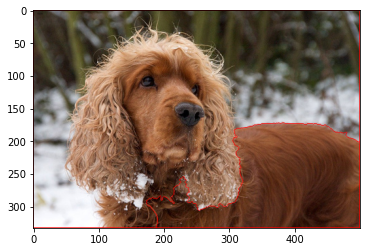

<Figure size 432x288 with 0 Axes>

In [59]:
J1 = cv2.imread(dir_imagenes+archivos[9])
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(J1,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0


markers = cv2.watershed(J1,markers)
J1[markers == -1] = [255,0,0]
plt.imshow(J1)
plt.figure()


<Figure size 432x288 with 0 Axes>

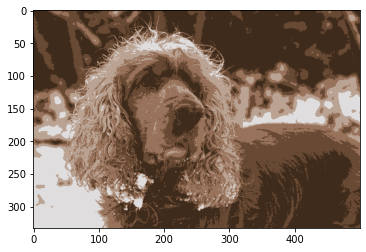

<Figure size 432x288 with 0 Axes>

In [60]:
J1 = cv2.imread(dir_imagenes+archivos[9])
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
twoDimage = J1.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
attempts=15
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((J1.shape))
plt.figure()
plt.imshow(result_image)
plt.figure()


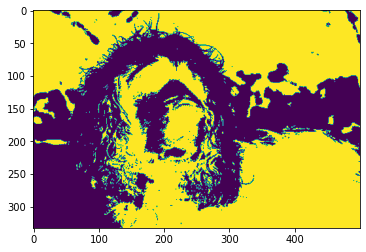

In [61]:
sample_image = cv2.imread(dir_imagenes+archivos[9])
img = cv2.cvtColor(sample_image,cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

plt.imshow(thresh)

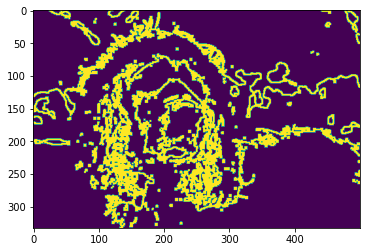

In [62]:
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.imshow(edges)

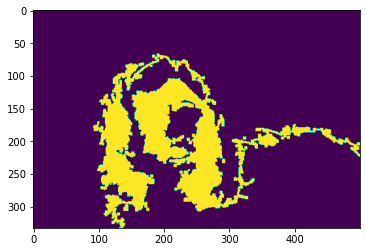

In [63]:
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros(np.shape(thresh), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.imshow(masked)

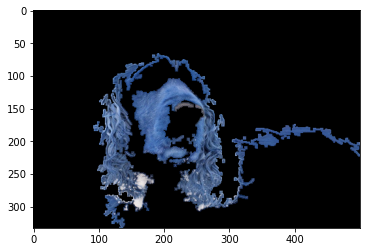

In [64]:
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(segmented)

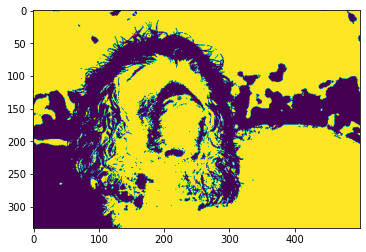

In [65]:
from skimage.filters import threshold_otsu
J1 = cv2.imread(dir_imagenes+archivos[9])        
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
img_gray=cv2.cvtColor(J1,cv2.COLOR_RGB2GRAY)

thresh = threshold_otsu(img_gray)
img_otsu  = img_gray < thresh

plt.imshow(img_otsu)

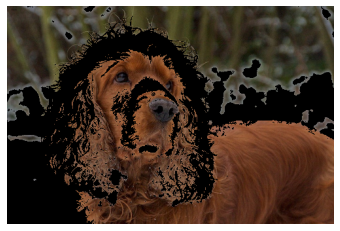

In [66]:
def filter_image(image, mask):

    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask

    return np.dstack([r,g,b])

filtered = filter_image(J1, img_otsu)

plt.axis('off')
plt.imshow(filtered)



### mAP

In [2]:
def average_precision(label, prediction):
    # Ordena los píxeles de la predicción de mayor a menor confianza
    sorted_prediction = sorted(prediction, key=lambda x: x[1], reverse=True)
    
    # Inicializa variables para el cálculo de la precisión promedio
    true_positive = 0
    false_positive = 0
    total_true = sum([1 for l in label if l[1] == 1])  # Cuenta el número total de píxeles verdaderos
    
    # Calcula la precisión promedio interpolada
    precision_sum = 0.0
    recall_levels = [0.0] + [i / total_true for i in range(1, total_true + 1)]
    
    for recall_level in recall_levels:
        # Encuentra los píxeles recuperados hasta el nivel de recuperación actual
        relevant_predictions = [p for p in sorted_prediction if p[1] >= recall_level]
        
        # Cuenta los verdaderos positivos y falsos positivos hasta el nivel de recuperación actual
        true_positive += sum([1 for p in relevant_predictions if p[0] in label and p[1] >= recall_level])
        false_positive += sum([1 for p in relevant_predictions if p[0] not in label or p[1] < recall_level])
        
        # Calcula la precisión y agrega su puntaje a la suma total
        precision = true_positive / (true_positive + false_positive)
        precision_sum += precision
    
    # Calcula la precisión promedio interpolada para la imagen
    average_precision = precision_sum / len(recall_levels)
    return average_precision
  
def calculate_mAP(labels, predictions):
    total_classes = len(labels)
    total_ap = 0.0
    
    for class_idx in range(total_classes):
        class_labels = labels[class_idx]
        class_predictions = predictions[class_idx]
        
        num_images = len(class_labels)
        class_ap = 0.0
        
        for image_idx in range(num_images):
            label = class_labels[image_idx]
            prediction = class_predictions[image_idx]
            
            ap = average_precision(label, prediction)
            class_ap += ap
        
        class_ap /= num_images
        total_ap += class_ap
    
    mAP = total_ap / total_classes
    return mAP

# Ejemplo de uso:
labels = [[label1, label2, ...], [label1, label2, ...], ...]  # Etiquetas de segmentación para cada clase y cada imagen
predictions = [[prediction1, prediction2, ...], [prediction1, prediction2, ...], ...]  # Predicciones generadas por el modelo para cada clase y cada imagen

mAP = calculate_mAP(labels, predictions)
print("mAP:", mAP)

NameError: name 'label1' is not defined

## Texturas

In [4]:
def mu_n(histograma, m, n):
    """Función que calcula el momento n.

    Args:
        histograma: histograma
        m (_type_): la media
        n (_type_): el momento a calcular
    """
    mu_n=0
    for i in range (256):
        mu_n=mu_n+((i-m)**n)*histograma[i]
    return mu_n

def calcular_descriptores_de_histograma(I):
    '''
    Calcula el histograma normalizado de la imagen I.
    Devuelve descriptores sobre el histograma calculado
    
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)

    Returns
    -------
    mean : double
    R : double
    skewness : double
    flatness : double
    uniformity : double
    entropy : double

    '''
    # calcular el histograma normalizado  
    numBins = 256
    histograma, bin_edges = np.histogram(I[:], np.arange(numBins+1), density=True)
    m=0
    entropy=0
    for i in range(numBins):
        m=m+i*histograma[i]
        if histograma[i]>0:
            entropy=entropy-(histograma[i]*np.log2(histograma[i]))
    mu2=mu_n(histograma, m,2)
    mu3=mu_n(histograma, m,3)
    mu4=mu_n(histograma, m,4)

    mean=m
    R=1-1/(1+mu2)
    skewness=mu3
    flatness=mu4
    uniformity = np.sum(histograma**2)
   
    return mean, R, skewness, flatness, uniformity, entropy

def calcular_descriptores_de_matriz_de_coocurrencia(I, distance, angle, levels=256, debug=False):
    '''
    Calcula la matriz de coocurrencia NORMALIZADA para la imagen I 
    para la combinación (distancia, angulo) deseado  
    Devuelve descriptores sobre la matriz de coocurrencia calculada
    Se implementa con funciones adecuadas de: 
        skimage.feature
       
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)
    distance : int, optional
        Distancia entre pixeles para calcular la coocurrencia.
    angle : double, optional
        Angulo (en radianes con respecto a la horizontal) para calcular la coocurrencia. 
    levels : int, optional . Por defecto 256.
        Usar solo para debuggear en imagenes artificiales pequeñas
    debug: bool, optional
        En caso de ser verdadero, imprime la matriz de coocurrencia 
    Returns
    -------
    contrast : double
    dissimilarity : double
    homogeneity : double
    energy : double
    correlation : double

    '''
    matriz_coocurrencia=greycomatrix(I, [distance], [angle],levels=levels)
    if debug:
        print("Matriz de coocurrencia: \n", matriz_coocurrencia[:, :, 0, 0])
    contrast = greycoprops(matriz_coocurrencia, 'contrast')[0][0]
    dissimilarity = greycoprops(matriz_coocurrencia, 'dissimilarity')[0][0]
    homogeneity = greycoprops(matriz_coocurrencia, 'homogeneity')[0][0]
    energy = greycoprops(matriz_coocurrencia, 'energy')[0][0]
    correlation = greycoprops(matriz_coocurrencia, 'correlation')[0][0]

    return contrast, dissimilarity, homogeneity, energy, correlation

def calcular_descriptores(I, angulo, distancia, datos, textura, animal):
    """Calcula los descriptores de histograma y de matriz de coocurrencia. Luego appendea a la lista datos.
    """
    mean, R, skewness, flatness, uniformity, entropy=calcular_descriptores_de_histograma(I)
    contrast, dissimilarity, homogeneity, energy, correlation=calcular_descriptores_de_matriz_de_coocurrencia(I, distancia, angulo, levels=256, debug=False)
    datos.append([textura,animal, mean, R, skewness, flatness, uniformity, entropy, contrast, dissimilarity, homogeneity, energy, correlation])
    return(datos)


def procesar_carpeta_texturas(direccion_img, direccion_lbl, distancia, angulo, plot=False):
    """ 
    Entra a la carpeta donde estan las imagenes de las texturas y procesa cada imagen. Devuelve los datos en una lista
    """

    datos=[["Raza", "Animal","Mean", "R", "Skewness", "Flatness", "Uniformity", "Entropy", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation"]]
    animales = os.listdir(direccion_img)
    
    for animalito in animales:

        nombre_raza = animalito.rsplit('_', 1)[0]
        if nombre_raza[0].isupper():
            animal = 'Gato'
        else:
            animal = 'Perro'
        try:
            I = cv2.imread(direccion_img+animalito)
            I=I[:,:,0]
            nombre_archivo_mascara = os.path.splitext(animalito)[0] + '.png'
            ruta_mascara = os.path.join(direccion_lbl, nombre_archivo_mascara)
            mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
            #probar cual queda  mejor
            #mascara_binaria = cv2.compare(mascara, 1, cv2.CMP_EQ) | cv2.compare(mascara, 3, cv2.CMP_EQ)
            mascara_binaria_1 = cv2.compare(mascara, 1, cv2.CMP_EQ) 
            mascara_binaria_3 = cv2.compare(mascara, 3, cv2.CMP_EQ)

            mascara_binaria = cv2.bitwise_or(mascara_binaria_1, mascara_binaria_3)
            imagen_sin_fondo = cv2.bitwise_and(I, I, mask=mascara_binaria)
            if plot:
                fig, axs = plt.subplots(1, 3, figsize=(10, 4))

                axs[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
                axs[0].axis('off')
                axs[0].set_title('Imagen original')

                axs[1].imshow(mascara, cmap='gray')
                axs[1].axis('off')
                axs[1].set_title('Máscara')

                axs[2].imshow(cv2.cvtColor(imagen_sin_fondo, cv2.COLOR_BGR2RGB))
                axs[2].axis('off')
                axs[2].set_title('Imagen sin fondo')

                plt.tight_layout()
                plt.show()
            
            datos=calcular_descriptores(imagen_sin_fondo, angulo, distancia, datos, nombre_raza, animal)
        except:
            print(animalito)
                    
    return(datos)




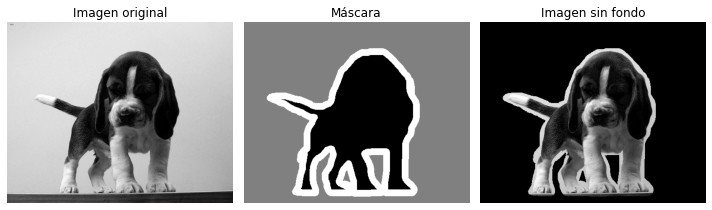

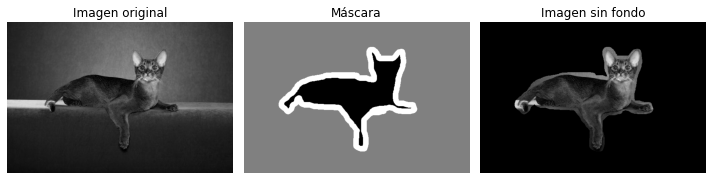

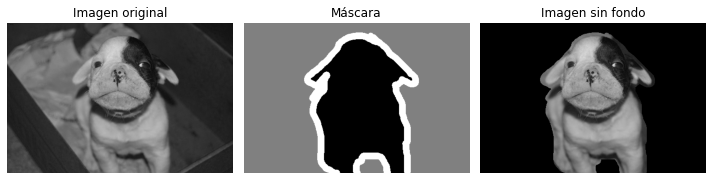

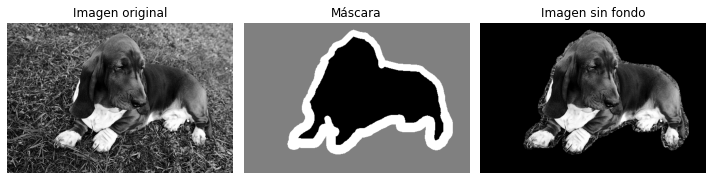

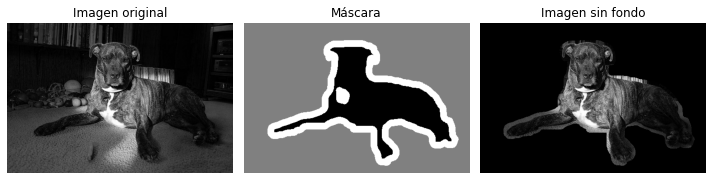

In [5]:
distancia=50
angulo=0
datos=procesar_carpeta_texturas(dir_imagenes_5,dir_labels_5, distancia, angulo, plot=True)
df = pd.DataFrame(datos[1:], columns=datos[0])

sn.pairplot(df, hue='Raza')

Abyssinian_34.jpg


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Egyptian_Mau_191.jpg
Abyssinian_100.mat


Corrupt JPEG data: premature end of data segment


Abyssinian_102.mat
Egyptian_Mau_177.jpg
Egyptian_Mau_167.jpg
Egyptian_Mau_139.jpg
Abyssinian_101.mat
Egyptian_Mau_145.jpg


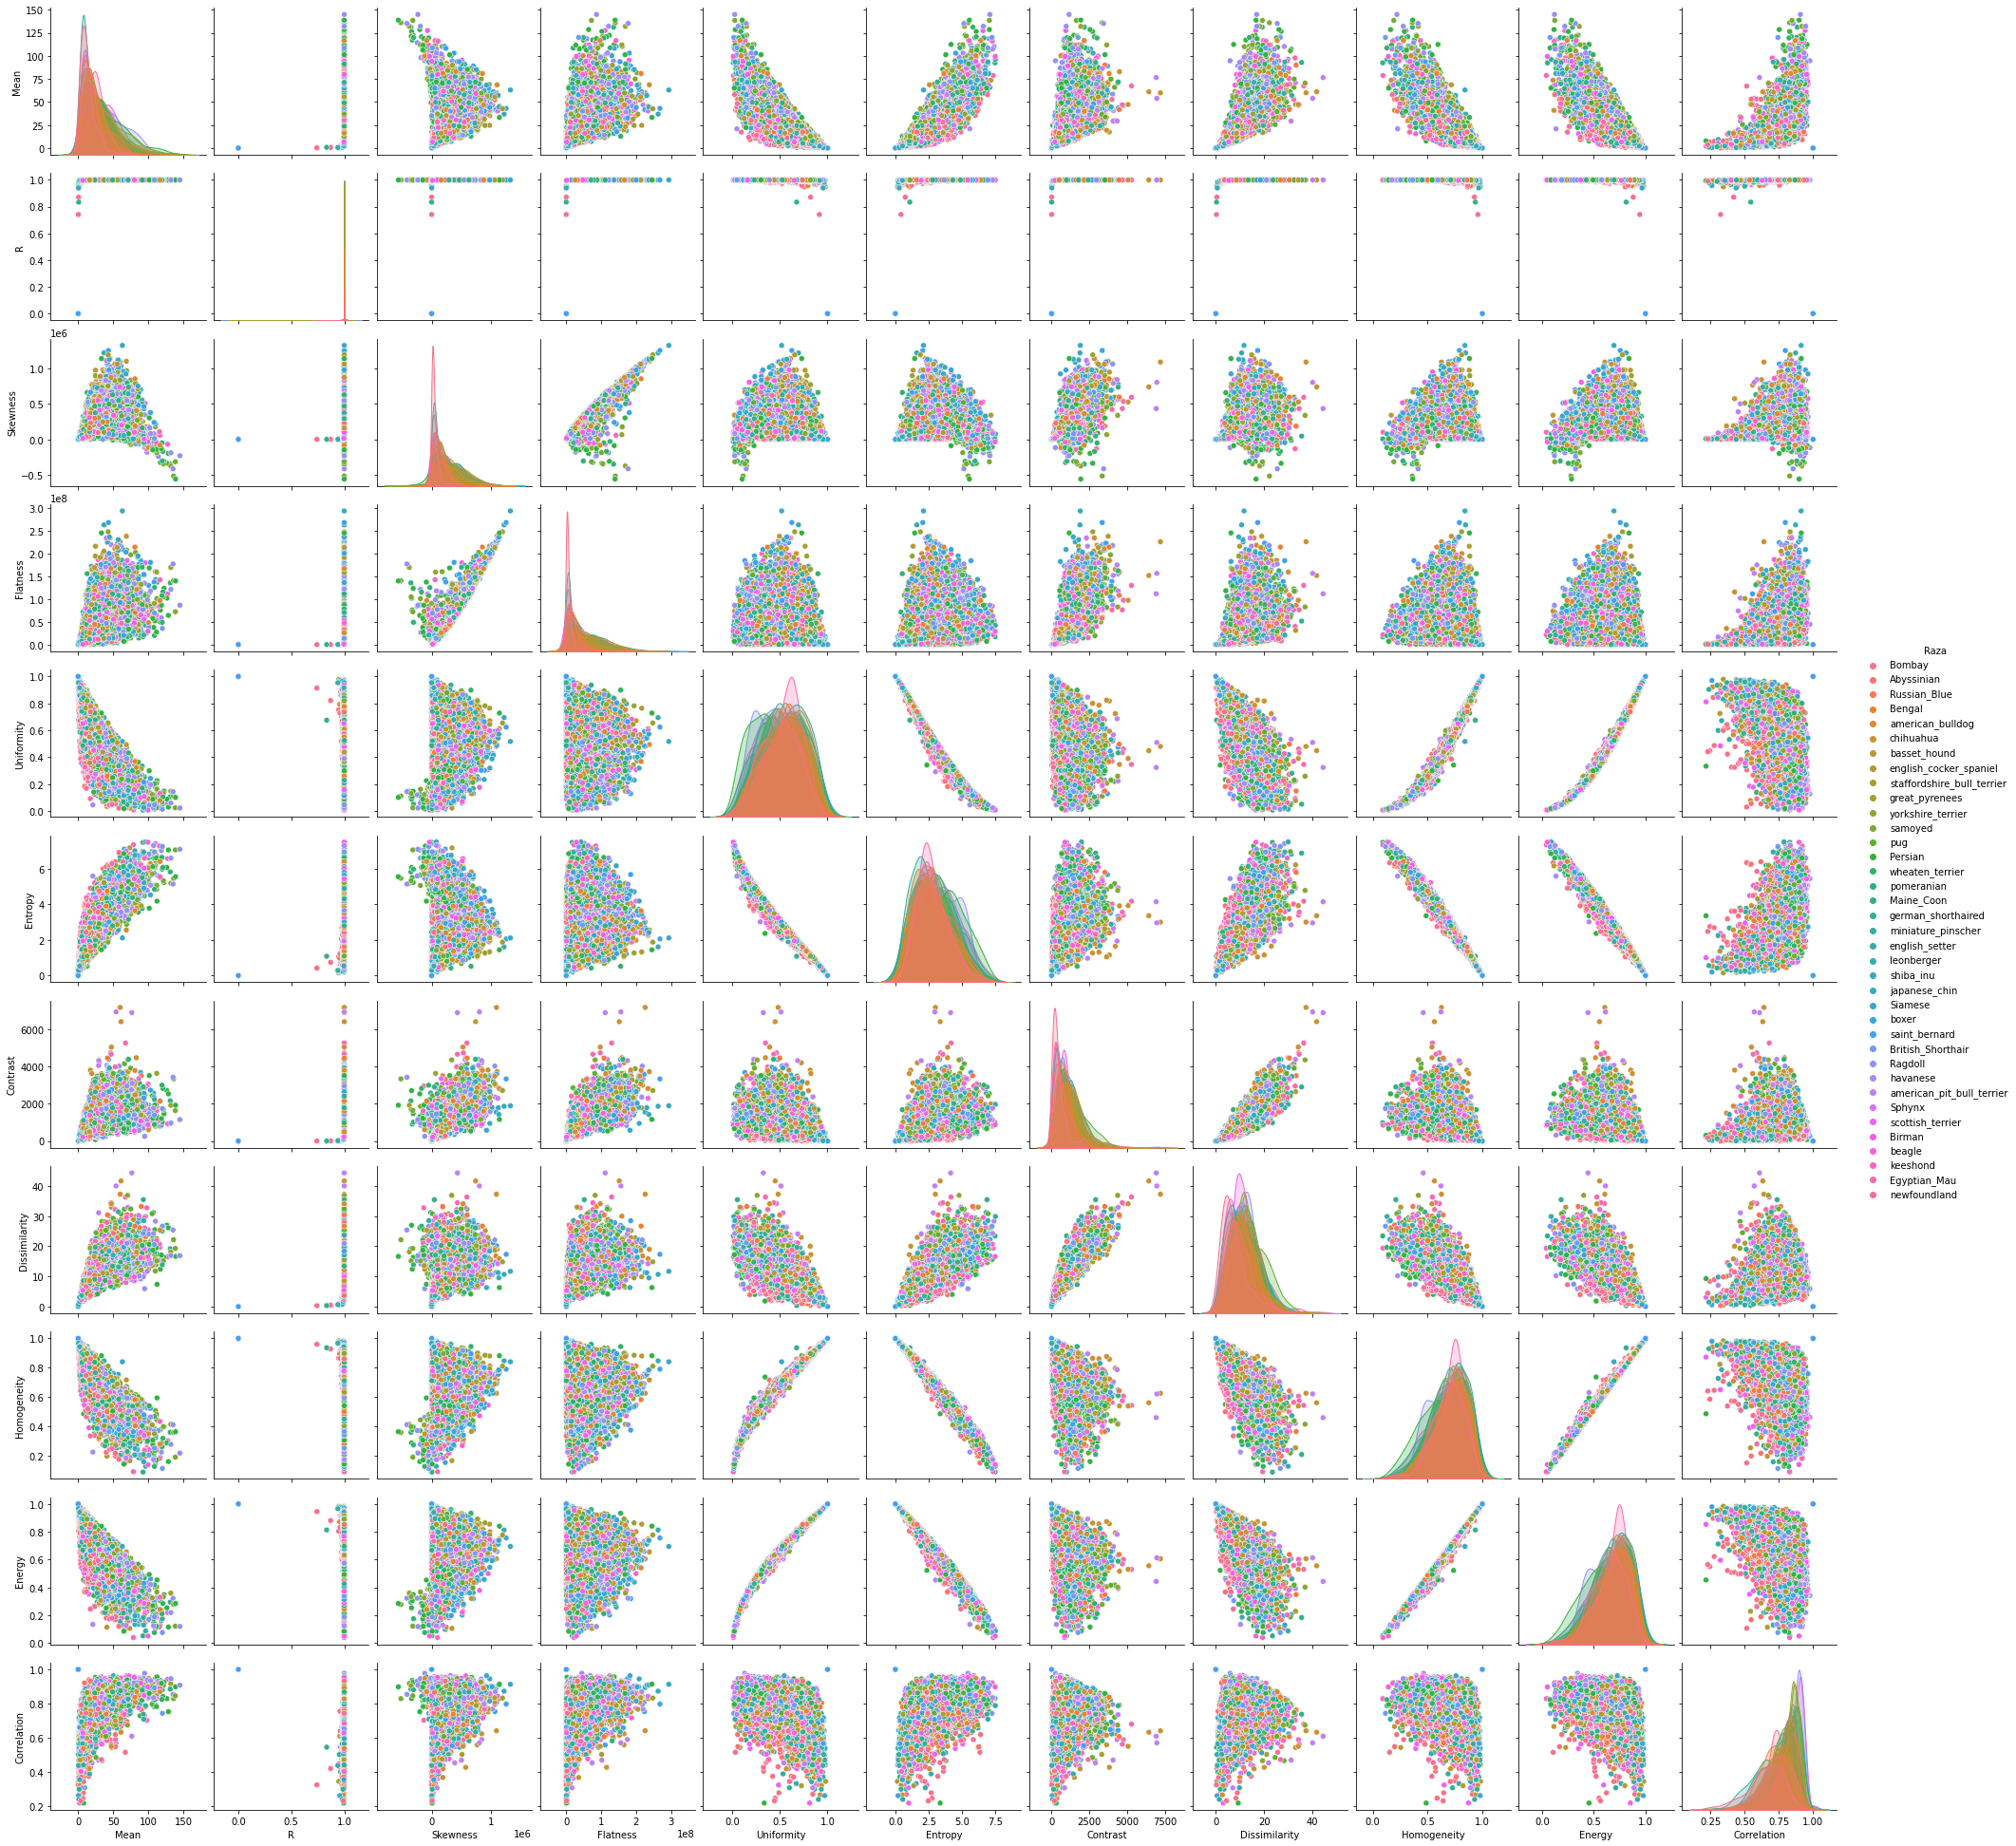

In [17]:
distancia=10
angulo=0
datos=procesar_carpeta_texturas(dir_imagenes,dir_labels, distancia, angulo, plot=False)
df = pd.DataFrame(datos[2:], columns=datos[0])

df.to_csv(f"datos_{distancia}_{angulo.csv}", index=False)
sn.pairplot(df, hue='Raza')

In [8]:
df = pd.read_csv('datos_10_angulo.csv')
df_gatos = df[df['Animal'] == 'Gato']
df_perros = df[df['Animal'] == 'Perro']
df.head()

Raza Animal       Mean         R       Skewness      Flatness  \
0            Bombay   Gato  13.481856  0.999151  120469.595127  1.675950e+07   
1        Abyssinian   Gato  10.863739  0.998914   97192.449932  1.419161e+07   
2      Russian_Blue   Gato  60.192069  0.999844  499705.120699  1.040329e+08   
3            Bengal   Gato   9.563392  0.998739   74250.384992  9.206969e+06   
4  american_bulldog  Perro  25.666635  0.999719  535214.463038  1.083694e+08   

   Uniformity   Entropy     Contrast  Dissimilarity  Homogeneity    Energy  \
0    0.627634  2.263173   684.640278       8.851826     0.780709  0.768837   
1    0.703559  1.803500   471.511869       6.354656     0.823064  0.816136   
2    0.309275  4.510400  2195.256141      22.597279     0.542406  0.527675   
3    0.743048  1.580837   426.360980       6.292463     0.840507  0.835147   
4    0.613241  2.430757  1730.331595      13.442415     0.771339  0.758518   

   Correlation  
0     0.712202  
1     0.748060  
2     0.830144  
3     0.735682  
4     0.762014

In [47]:
df_numerico=df.copy()
# Convertir la columna "Raza" en una serie categórica
categorical_series = df['Raza'].astype('category')

# Obtener los códigos numéricos para cada raza
numeric_codes = categorical_series.cat.codes

# Reemplazar la columna "Raza" con los códigos numéricos
df_numerico['Raza'] = numeric_codes

df_numerico[df_numerico.columns].corr()['Raza']

Raza             1.000000
Mean            -0.041438
R               -0.009676
Skewness         0.050112
Flatness         0.041307
Uniformity       0.089082
Entropy         -0.078149
Contrast         0.069184
Dissimilarity    0.025875
Homogeneity      0.074504
Energy           0.081157
Correlation     -0.052011
Name: Raza, dtype: float64

In [19]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df[selected_columns].values.astype(np.float64)
y = df['Raza'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
clasificador = KNeighborsClassifier(n_neighbors=10)
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# # Calcular la matriz de confusión
# cm = confusion_matrix(y_test, y_pred)
# print("Matriz de confusión:")
# cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
# cmd.plot()

Tasa de aciertos: 0.048212351029252434


Tasa de aciertos: 0.15622389306599832
Matriz de confusión:


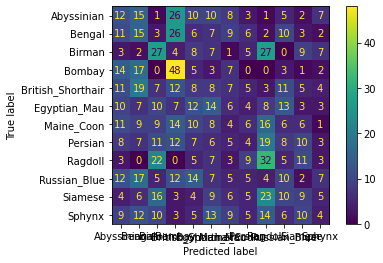

In [11]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df_gatos[selected_columns].values.astype(np.float64)
y = df_gatos['Raza'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
clasificador = KNeighborsClassifier(n_neighbors=20)
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

Tasa de aciertos: 0.07775551102204409
Matriz de confusión:


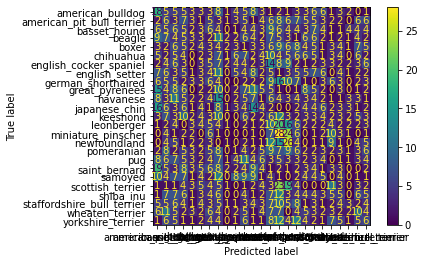

In [12]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df_perros[selected_columns].values.astype(np.float64)
y = df_perros['Raza'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
clasificador = KNeighborsClassifier(n_neighbors=50)
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

Tasa de aciertos: 0.24644945697577275
Matriz de confusión:


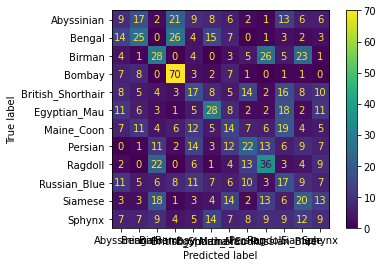

In [15]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df_gatos[selected_columns].values.astype(np.float64)
y = df_gatos['Raza'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)


clasificador=RandomForestClassifier()
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

Tasa de aciertos: 0.11983967935871744
Matriz de confusión:


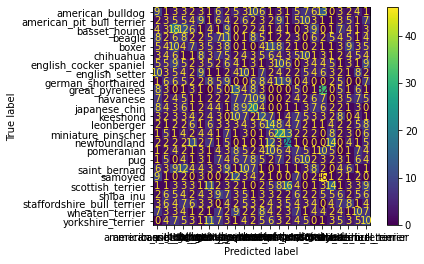

In [16]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df_perros[selected_columns].values.astype(np.float64)
y = df_perros['Raza'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)


clasificador=RandomForestClassifier()
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

In [17]:
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



In [18]:
all_columns = df.columns.tolist()

selected_columns = [col for col in all_columns if col not in ["Raza", "Animal"]]
X = df_gatos[selected_columns].values.astype(np.float64)
y = df_gatos['Raza'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4bf8c84430>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4bd9d63970>})

In [19]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 143}


Tasa de aciertos: 0.2781954887218045
Matriz de confusión:


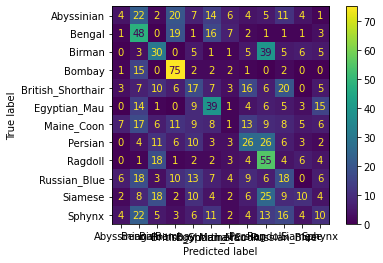

In [24]:
y_pred = best_rf.predict(X_test)

# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

#Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

## Color

https://towardsdatascience.com/group-similar-image-by-using-the-gaussian-mixture-model-em-algorithm-438e9744660c

https://medium.com/lifeandtech/color-segmentation-using-gmm-7a8d900e48b

## Algoritmo

https://towardsdatascience.com/dog-breed-classification-using-deep-learning-concepts-23213d67936c

## Prediccion

Prediccion en chiste: pasarle una persona y ver que raza serías :)

## Probando cosas con yolov8

https://docs.ultralytics.com/usage/python/#predict

In [52]:

!yolo predict model=yolov8n-seg.pt source='/home/sere/Escritorio/trabajotimag/images_5/Abyssinian_1.jpg' imgsz=320

Ultralytics YOLOv8.0.120 🚀 Python-3.8.10 torch-1.10.1+cpu CPU
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

image 1/1 /home/sere/Escritorio/trabajotimag/images_5/Abyssinian_1.jpg: 224x320 1 cat, 129.5ms
Speed: 5.7ms preprocess, 129.5ms inference, 12.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/segment/predict2


<Figure size 432x288 with 0 Axes>

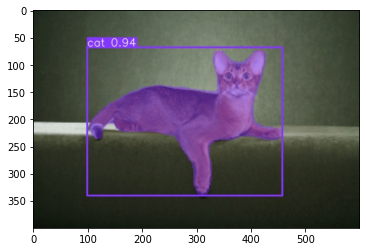

<Figure size 432x288 with 0 Axes>

In [53]:

J1 = cv2.imread("/home/sere/Escritorio/trabajotimag/runs/segment/predict2/Abyssinian_1.jpg")
J1=cv2.cvtColor(J1, cv2.COLOR_BGR2RGB)
plt.imshow(J1)
plt.figure()




image 1/1 /home/sere/Escritorio/trabajotimag/images_small/Abyssinian_1.jpg: 448x640 1 cat, 9778.7ms
Speed: 56.1ms preprocess, 9778.7ms inference, 85.0ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 432x288 with 0 Axes>

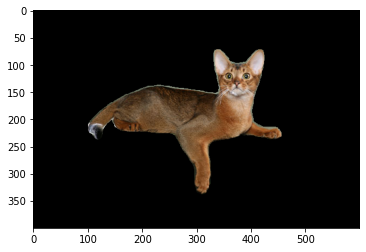

<Figure size 432x288 with 0 Axes>

In [30]:
from ultralytics import YOLO
model = YOLO("yolov8m-seg.pt")
path="/home/sere/Escritorio/trabajotimag/images_small/Abyssinian_1.jpg"
results = model.predict(path, classes=15)
result = results[0]
masks = result.masks
mask1 = masks[0]
mask = mask1.data[0].numpy()
polygon = mask1.xy[0]
mask = np.zeros_like(img)
polygon = np.array(polygon, dtype=np.int32)
# Dibuja el polígono en la máscara en blanco
cv2.fillPoly(mask, [polygon], (255, 255, 255))

# Aplica la máscara a la imagen para borrar el fondo
result = cv2.bitwise_and(img, mask)
J1=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(J1)
plt.figure()


{'0': 'Bombay', '1': 'Abyssinian', '2': 'Russian_Blue', '3': 'Bengal', '4': 'Persian', '5': 'Maine_Coon', '6': 'Siamese', '7': 'British_Shorthair', '8': 'Ragdoll', '9': 'Sphynx', '10': 'Birman', '11': 'Egyptian_Mau'}


[ WARN:0@4.882] global loadsave.cpp:244 findDecoder imread_('annotations/trimaps/a.png'): can't open/read file: check file path/integrity

image 1/1 /home/sere/Escritorio/trabajotimag/a.jpeg: 640x608 1 cat, 1205.9ms
Speed: 9.8ms preprocess, 1205.9ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)


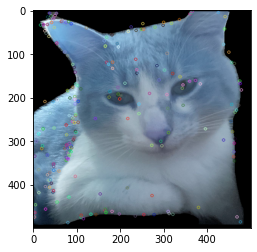

Test images classified.
['Birman']


In [1]:
#import inferencia_eval from bag_of_words.ipynb
from funciones import inferencia_eval , get_classes
import pandas as pd
nombre_csv="datos_gatos.csv"
#make_dataset(dir_imagenes, nombre_csv)

df = pd.read_csv(nombre_csv)
df=df[df['Family'] == 'Gato']
classes=get_classes(df)
no_clusters=100
kernel="precomputed"
labels="/home/sere/Escritorio/trabajotimag/annotations/trimaps"
inferencia_eval("/home/sere/Escritorio/trabajotimag/a.jpeg", "/home/sere/Escritorio/trabajotimag/annotations/trimaps", no_clusters, kernel, classes)